In [9]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
import numpy as np 

In [16]:
image = cv2.imread('/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Filtered_Frames/Frame_16.png')
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


[[[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 [[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 [[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 ...

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 55  52  51]
  [ 55  52  51]
  [ 55  52  51]]

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 57  54  53]
  [ 57  54  53]
  [ 56  53  52]]

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 59  56  55]
  [ 59  56  55]
  [ 57  54  53]]]


In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [10]:
from segment_anything import build_sam, SamPredictor 
# input_box = np.array([1123.0, 589.0, 1194.0, 678.0])
input_point = np.array([[1158.5, 633.5]])
input_label = np.array([1])

In [26]:
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

0.0019208140432098765


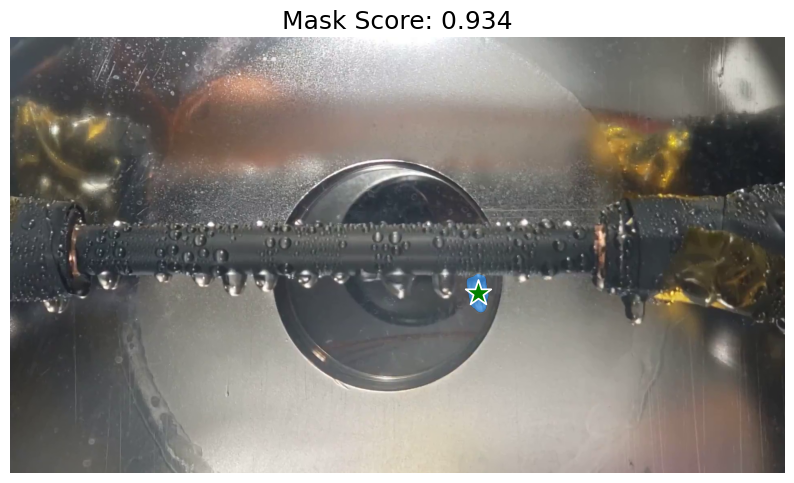

In [45]:
mask = masks[0]
score = scores[0]
positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
area = positive_pixel_count / (w*h)
print(area)

# pixels = cv2.countNonZero(mask)
# print(pixels)
# for i, (mask, score) in enumerate(zip(masks, scores)):
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show() 

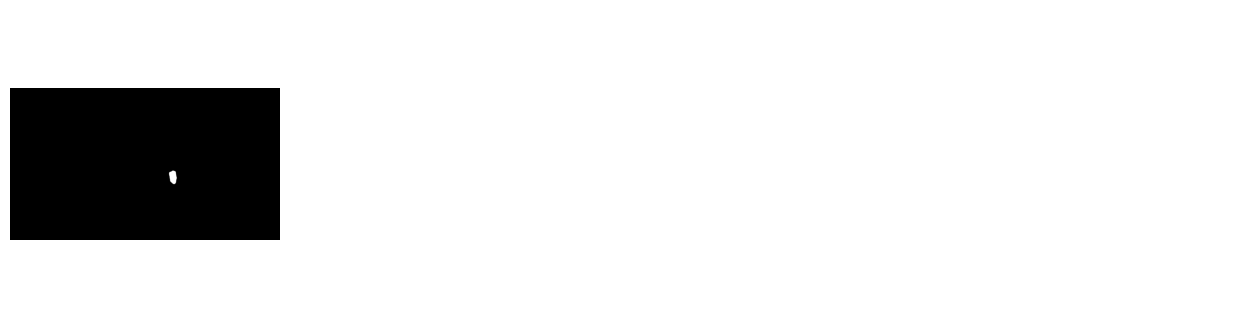

0

In [42]:
import supervision as sv

mask_bw = sv.plot_images_grid(
    images = masks,
    grid_size= (1,4),
    size = (16,4)
)

cv2.countNonZero(mask_bw)


In [66]:
def read_filtered_frames(filename):
    lines = []
    with open(filename, 'r') as file:
        for line in file:
            # Each line contains coordinates in the format: x1,y1,x2,y2
            coordinates = list(map(float, line.strip().split(',')))
            lines.append(coordinates)
    return lines

def calculate_midpoint(bbox):
    l, x1, y1, x2, y2 = bbox
    return [(x1 + x2) / 2, (y1 + y2) / 2]

def process_line(line,predictor,areas,frame_num):
    # Read frame
    # print(line)
    frame_path = f"/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Filtered_Frames/Frame_{int(line[0])}.png"
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate midpoint of bounding box
    bbox_midpoint = calculate_midpoint(line)
    input_point = np.array([bbox_midpoint])
    input_label = np.array([1])

    
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    mask = masks[0]
    score = scores[0]
    positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
    h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
    area = positive_pixel_count / (w*h)
    print(area)
    areas.append(area)
    frame_num.append(int(line[0]))
    # print(f"Processing frame {line} with midpoint {bbox_midpoint}")

filtered_frames_file = "/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/BG_Subtraction/filtered_frames.txt"
lines = read_filtered_frames(filtered_frames_file)
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
areas = []
frame_num = []
for line in lines:
    process_line(line,predictor,areas,frame_num)


0.0019208140432098765
0.001976273148148148
0.0020495756172839506
0.001077835648148148
0.0019039351851851852
0.001927565586419753
0.002040895061728395
0.0023046875
0.0017255015432098765
0.0019622878086419755
0.0007846257716049383
0.0006534529320987655
0.0006524884259259259
0.0009505208333333334
0.0004099151234567901
0.0014115547839506173
0.0009982638888888888
0.0009968171296296296
0.0009837962962962962
0.0009833140432098765
0.0009977816358024692
0.0009765625
0.0009919945987654321
0.0009837962962962962
0.000980420524691358
0.0009948881172839505
0.002065972222222222
0.0009847608024691357
0.000980420524691358
0.0009847608024691357
0.0009992283950617283
0.0010267168209876544
0.0010190007716049383
0.0020008680555555556
0.0004296875
0.002019675925925926
0.0021233603395061727
0.0018865740740740742
0.002113233024691358
0.00199266975308642
0.00039207175925925927
0.0008709490740740741
0.00035493827160493826
0.002083815586419753
0.0014718364197530865
0.0020707947530864195
0.0017544367283950618
0.0

1080 1920


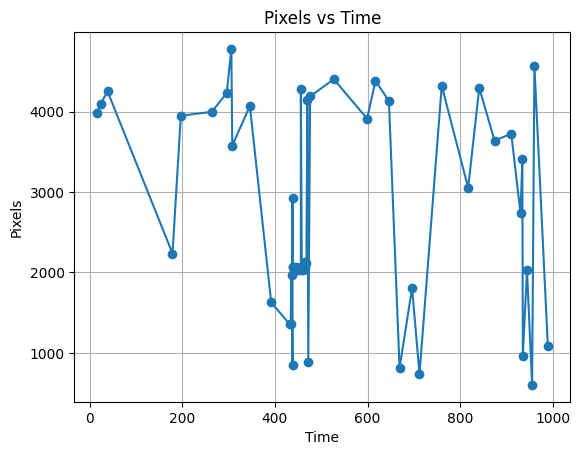

In [71]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
# Plotting the data
print(h,w)
plt.plot(frame_num, areas_np*h*w, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.title('Pixels vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()


1080 1920


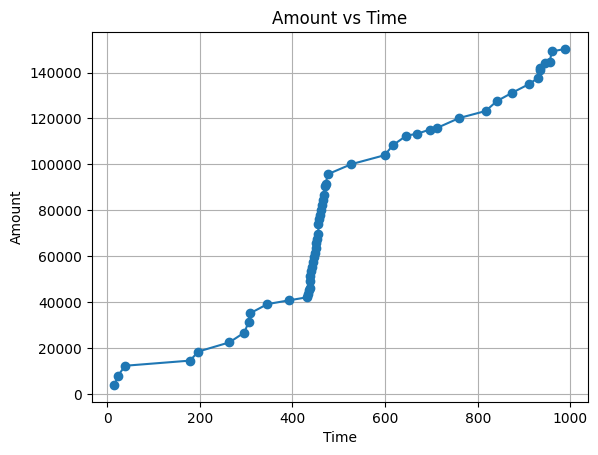

In [73]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
areas_np = areas_np*h*w

cumulative_areas = [sum(areas_np[:i+1]) for i in range(len(areas_np))]
# Plotting the data
print(h, w)
plt.plot(frame_num, cumulative_areas, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Amount vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()